In [14]:
import torch, gc
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
from PIL import Image
from numpy import uint8

from src.dataset import ImageDataset
from src.utils import get_indices, plot_result, psnr
from src.loss_functions import FFTloss, VGGPerceptualLoss

from mwcnn.mwcnn import MWCNN
from mwcnn.training import Trainer

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()

# Dataset part used for testing
VALIDATION_SPLIT = 0.15
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 5
# Full Dataset path
TEST_DATASETS = ['val']
TRAIN_DATASETS = ['train']
ROOTDIR = '../data/'

# Training Epochs
EPOCHS = 100

IMAGESIZE = 1024

gc.collect()
torch.cuda.empty_cache()

## 1 Initiate train and test loader

In [2]:
train_image_dataset = ImageDataset(ROOTDIR, TRAIN_DATASETS, normalize="percentile", image_size=IMAGESIZE)
train_indices, validation_indices = get_indices(len(train_image_dataset), train_image_dataset.root_dir, VALIDATION_SPLIT, new=True)
train_sampler, validation_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(validation_indices)

trainloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=train_sampler)
validationloader = torch.utils.data.DataLoader(train_image_dataset, BATCH_SIZE, sampler=validation_sampler)

test_image_dataset = ImageDataset(ROOTDIR, TEST_DATASETS, normalize="percentile", image_size=IMAGESIZE)
testloader = torch.utils.data.DataLoader(test_image_dataset, 1)

data\mip2edof_2samples/e9_5_GLM87a_cycle1_8_8


FileNotFoundError: [Errno 2] No such file or directory: 'data\\mip2edof_2samples/e9_5_GLM87a_cycle1_8_8'

## 1.1 Show example of images

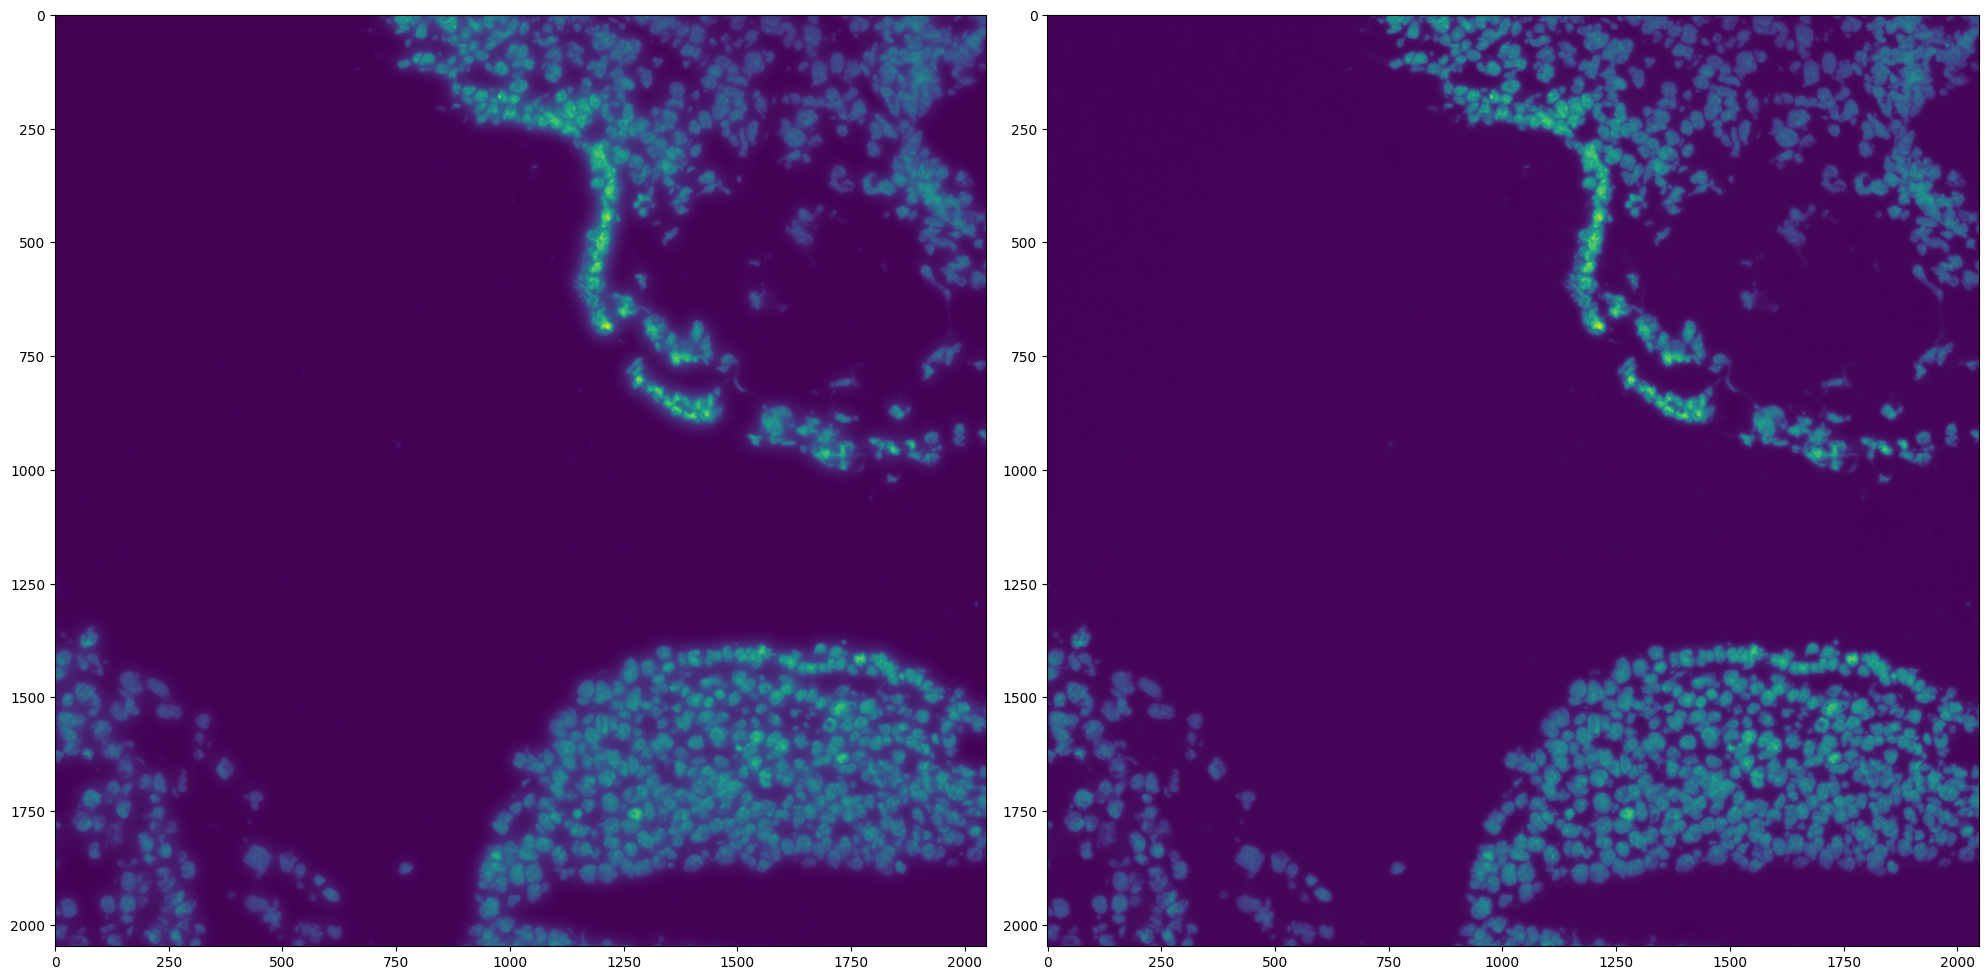

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 60))
image_index = 0
sample = train_image_dataset[image_index]

ax[0].imshow(sample["input_image"].squeeze(), aspect='equal')
ax[1].imshow(sample["output_image"].squeeze(), aspect='equal')

plt.tight_layout()
plt.show()

## 2 Initiate models

In [ ]:
N_FEATS = 64
local_criterion = torch.nn.L1Loss()
global_criteria = [VGGPerceptualLoss(resize=False), FFTloss(device=device, han_window=True), None]
global_criteria_scale = [1.0, 0.001, None]
names = ["vgg", "fft", "none"]
models = []
for criterion, scale, name in zip(global_criteria, global_criteria_scale, names):
    # Create model
    MWCNN_model = MWCNN(n_feats=N_FEATS, n_colors=1, batch_normalize=True).to(device)
    # Training
    MWCNN_trainer = Trainer(MWCNN_model, local_criterion=local_criterion, global_criterion=criterion, scale=scale, device=device, clear_cache=True)
    train_loss_record, validation_loss = MWCNN_trainer.train(EPOCHS,trainloader,mini_batch=1)
    models.append({"model": MWCNN_model, "train_loss": train_loss_record, "validation_loss": validation_loss})

    torch.save(MWCNN_model, f'mwcnn/models/MWCNN_model_{name}_feats_{N_FEATS}_batchnorm.pth')
    

## Show prediction results per model

C:\Users\jurri\AppData\Local\Temp\ipykernel_14016\3673249755.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


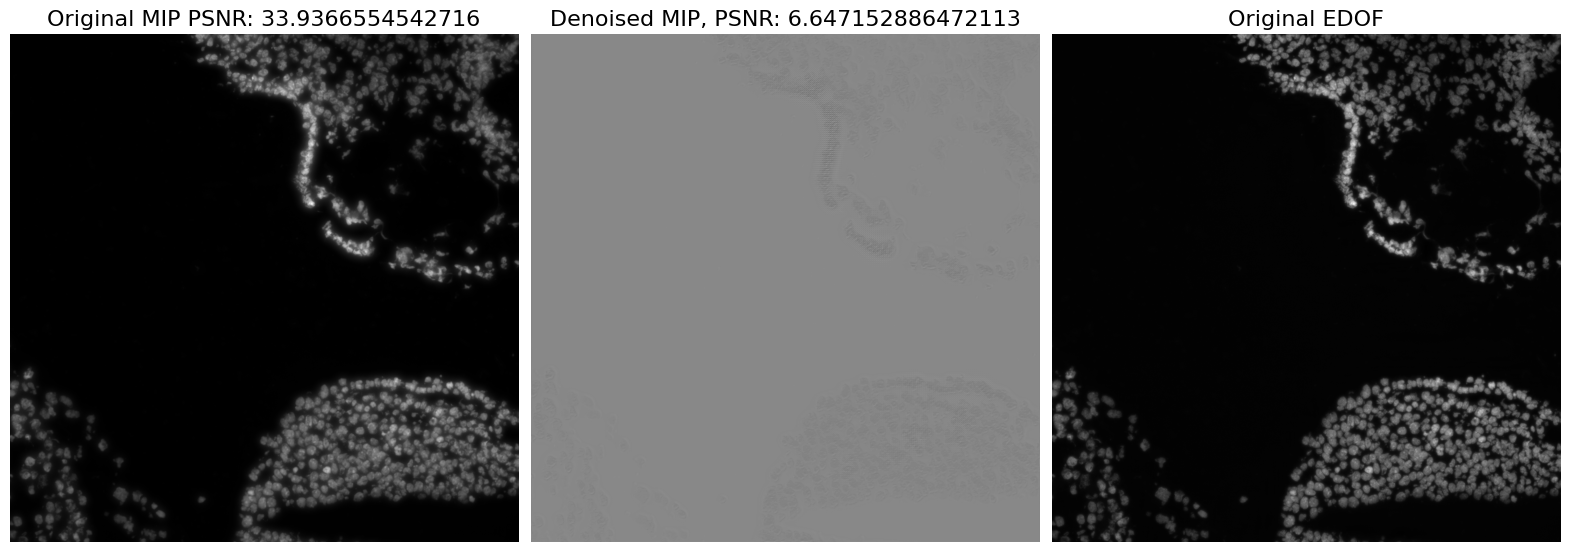

In [4]:
results = []
sample = test_image_dataset[0]
sharp = sample['output_image'].cpu().numpy().squeeze()
for model,name in zip(models, names):
    
    noisy = sample['input_image'][None,:,:,:].to(device)
    output = model(noisy)
    output = output.cpu().detach().numpy().squeeze()
    noisy = noisy.cpu().detach().numpy().squeeze()

    output_psnr = psnr(output, sharp)
    nosiy_psnr = psnr(noisy, sharp)
    
    results.append({
        "MIP": noisy,
        "pred": output,
        "EDOF": sharp,
        "original_score": nosiy_psnr,
        "improved_score": output_psnr,
        "model": name
    })

plot_result(results, "results of GAN experiment", save_path=None)